### Basic ISC



#### Import modules

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os, nilearn, pickle, glob,shutil
from nilearn import plotting, maskers, datasets
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from utils import *
import warnings
warnings.simplefilter("ignore")

#### Setup variables and filenames

In [3]:
recompute_results      = True
pairwise_flag          = True
n_iter                 = 1000
alpha                  = 0.05
twin_data_file         = '../data/00_dataset_info/twin_df.csv'
fmri_data_file         = '../data/03_extract_ts_aus/ts_array_shen268_pauli16_aan9.npy'
all293_rois_file       = '../data/02_rois_masks_maps/allcombined.nii'
masker_prefitting_file = '../data/02_rois_masks_maps/func.nii.gz'

isc_result_file_phase  = '../data/05_results/aus_isc_phase1000FDRq05.nii'
isc_result_file_perm   = '../data/05_results/aus_isc_perm1000_FDRq05.nii'
isc_npy_file           = '../data/05_results/aus_isc_perm1000_FDRq05.npy'


#### Load viewer info, set up masker, load timeseries

In [4]:
# load subject info
twin_df = pd.read_csv(twin_data_file)
sub_list = list(np.hstack((twin_df['twin_A_id'].values, twin_df['twin_B_id'].values)))
print("Number of subjects: " + str(len(sub_list)))

# prepare masker
isc_masker            = maskers.NiftiLabelsMasker(all293_rois_file);
isc_masker.fit(masker_prefitting_file);
print("Set up ISC masker")

# load timeseries, swap axes
ts_array = np.load(fmri_data_file)
ts_data = np.swapaxes(ts_array, 0, 2)
ts_data = np.swapaxes(ts_data, 0, 1)
print("Shape of time series structure: " + str(ts_data.shape))

Number of subjects: 200
Set up ISC masker
Shape of time series structure: (380, 293, 200)


#### Compute and Plot ISC (Phase Randomization)

Now computing phaseshift ISC ...


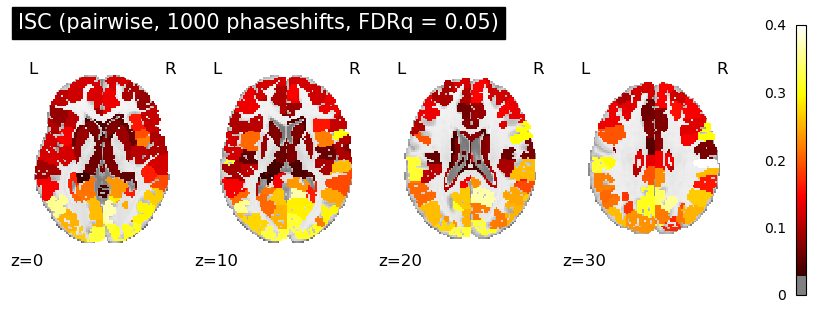

In [66]:
if recompute_results:
    
    # submit to ISC analysis, takes about 15-20 minutes on normal machine with 1000 shifts
    print('Now computing phaseshift ISC ...')
    ISC, p = partly_phaseshift_isc(ts_data, pairwise = pairwise_flag, summary_statistic = np.mean,
                                    n_shifts = n_iter, return_distribution = False)
    ISC[np.isnan(ISC)] = 0
    
    # Stats correction 
    q                               = multipletests(p[0, :], method='fdr_by')[1]
    corrected                       = q[np.newaxis, :] < alpha
    ISC[corrected == False]         = 0

    # Map to brain space
    curr_isc = np.reshape(ISC, (293,1)).T
    curr_img = isc_masker.inverse_transform(curr_isc);
    curr_img.to_filename(isc_result_file_phase)

else:
    curr_img = nilearn.image.load_img(isc_result_file_phase)

# Plot
fig = plt.figure(figsize=(8, 3))
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                   threshold    = 0.03, 
                                   vmax         = 0.4, 
                                   draw_cross   = False,
                                   display_mode = 'z',
                                   cut_coords   = [ 0, 10, 20, 30],
                                   annotate     = True,
                                   title = 'AUS ISC (pairwise, 1000 phaseshifts, FDRq = 0.05)',
                                   figure = fig);
plt.show();

#### Compute and Plot ISC (Permutation)

Assuming 200 subjects with 380 time points and 293 voxel(s) or ROI(s).
Now computing permutation ISC ...


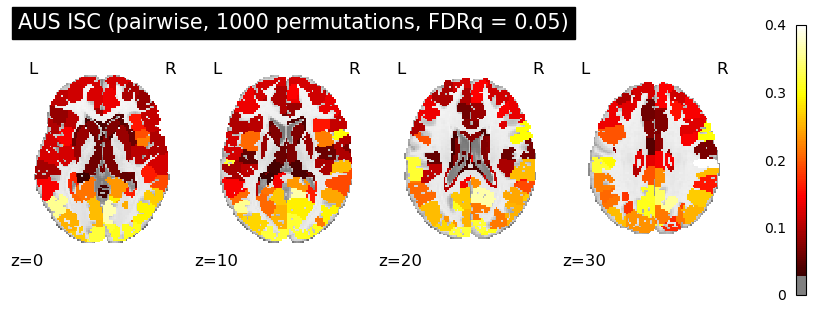

In [69]:
if recompute_results:
    
    # first, compute the individual isc and flatten into a one-subject-per-line matrix 
    input_isc = partly_isc(ts_data, pairwise=True, summary_statistic=None)
    
    # Compute permutation ISC
    print('Now computing permutation ISC ...')
    ISC, p, distribution = partly_permutation_isc(input_isc, pairwise= True, summary_statistic = 'mean', n_permutations = n_iter)
    
    # Correction 
    p = np.reshape(p, (293,1)).T
    ISC[np.isnan(ISC)]      = 0
    q                       = multipletests(p[0, :], method='fdr_by')[1]
    corrected               = q[np.newaxis, :] < alpha
    ISC[corrected == False] = 0

    # Map statistical results into brain space
    curr_isc = np.reshape(ISC, (293,1)).T
    curr_img = isc_masker.inverse_transform(curr_isc);
    curr_img.to_filename(isc_result_file_perm)
    np.save(isc_npy_file, curr_isc)

else:
    curr_img = nilearn.image.load_img(isc_result_file_perm)

# Plot
fig = plt.figure(figsize=(8, 3))
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                       threshold    = 0.03, 
                                       vmax         = 0.4, 
                                       draw_cross   = False,
                                       display_mode = 'z',
                                       cut_coords   = [ 0, 10, 20, 30],
                                       annotate     = True,
                                       title = 'AUS ISC (pairwise, 1000 permutations, FDRq = 0.05)',
                                       figure = fig);
plt.show();

#### Additionally, take a far more conservative approach

Assuming 200 subjects with 380 time points and 293 voxel(s) or ROI(s).
Now computing permutation ISC ...


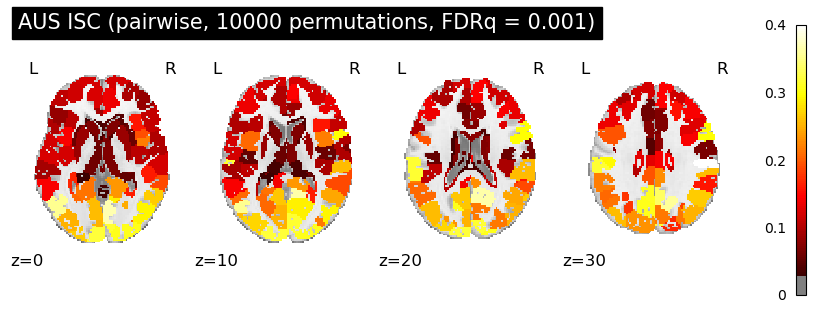

In [5]:
    
# first, compute the individual isc and flatten into a one-subject-per-line matrix 
input_isc = partly_isc(ts_data, pairwise=True, summary_statistic=None)
    
# Compute permutation ISC
print('Now computing permutation ISC ...')
ISC, p, distribution = partly_permutation_isc(input_isc, pairwise= True, summary_statistic = 'mean', n_permutations = 10000)
    
# Correction 
p = np.reshape(p, (293,1)).T
ISC[np.isnan(ISC)]      = 0
q                       = multipletests(p[0, :], method='fdr_by')[1]
corrected               = q[np.newaxis, :] < 0.001
ISC[corrected == False] = 0

# Map statistical results into brain space
curr_isc = np.reshape(ISC, (293,1)).T
curr_img = isc_masker.inverse_transform(curr_isc);

# Plot
fig = plt.figure(figsize=(8, 3))
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                       threshold    = 0.03, 
                                       vmax         = 0.4, 
                                       draw_cross   = False,
                                       display_mode = 'z',
                                       cut_coords   = [ 0, 10, 20, 30],
                                       annotate     = True,
                                       title = 'AUS ISC (pairwise, 10000 permutations, FDRq = 0.001)',
                                       figure = fig);
plt.show();

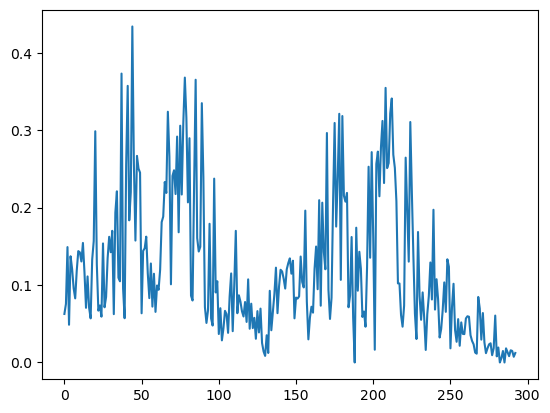

In [8]:
plt.plot(curr_isc.T)